## Combining data for all simulations (1960 - 2016)

In this notebook, we combine data for all simulations to make sure that all datafiles can be accessed within a single xarray dataset.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature

### Check data for overturning strength and transport diagnostics  

In [2]:
ppdir="/home/users/hkhatri/DePreSys4_Data/Data_Consolidated/"

# variable list to keep in the dataset
#var_list = ['hfbasin_atlantic', 'hfbasinpmdiff_atlantic', 'hfovgyre_atlantic', 'hfovovrt_atlantic', 'sophtadv_atlantic', 
#            'sltbasin_atlantic', 'sltbasinpmdiff_atlantic', 'sltovgyre_atlantic', 'sltovovrt_atlantic', 'sopstadv_atlantic',
#            'zomsfatl', 'time']

var_list = ['hfbasin_atlantic', 'sltbasin_atlantic', 'zomsfatl', 'zosalatl','zosrfatl','zotematl','time',
           'deptht_bounds', 'depthw_bounds']

ds = []

# Loop over year to combine indivual year files
for year in range(1960, 2017 ,2):
    
    d = xr.open_dataset(ppdir + str(year) + "_diaptr.nc", chunks={'r':1})
    d = d.get(var_list)
    ds.append(d)
    
ds = xr.concat(ds, dim='start_year')

ds = ds.assign(start_year = np.arange(1960, 2017, 2))

ds = ds.chunk({'start_year': 1})

print(ds)

<xarray.Dataset>
Dimensions:            (axis_nbounds: 2, deptht: 75, depthw: 75, r: 10, start_year: 29, time_counter: 125, x: 1, y: 451)
Coordinates:
  * depthw             (depthw) float32 0.0 1.0239066 ... 5596.249 5800.0
    nav_lon            (y, x) float32 dask.array<shape=(451, 1), chunksize=(451, 1)>
    nav_lat            (y, x) float32 dask.array<shape=(451, 1), chunksize=(451, 1)>
  * deptht             (deptht) float32 0.50576 1.5558553 ... 5902.0576
  * time_counter       (time_counter) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    time_centered      (start_year, time_counter) object dask.array<shape=(29, 125), chunksize=(1, 125)>
  * start_year         (start_year) int64 1960 1962 1964 1966 ... 2012 2014 2016
Dimensions without coordinates: axis_nbounds, r, x, y
Data variables:
    hfbasin_atlantic   (start_year, r, time_counter, y, x) float32 dask.array<shape=(29, 10, 125, 451, 1), chunksize=(1, 1, 125, 451, 1)>
    sltbasin_atlantic  (start_year, r, time_counter, y, x) fl

### Overturning Strength

In [3]:
# Check how Overturning strength looks like at 30 N, 40 N and 50 N

psi_max = ds.zomsfatl.mean(['x'])
psi_max = psi_max.assign_coords(y=ds.nav_lat.isel(x=0))
psi_max = psi_max.sel(y=[30., 50.], method="nearest")
lat = ['30 N', '50 N']

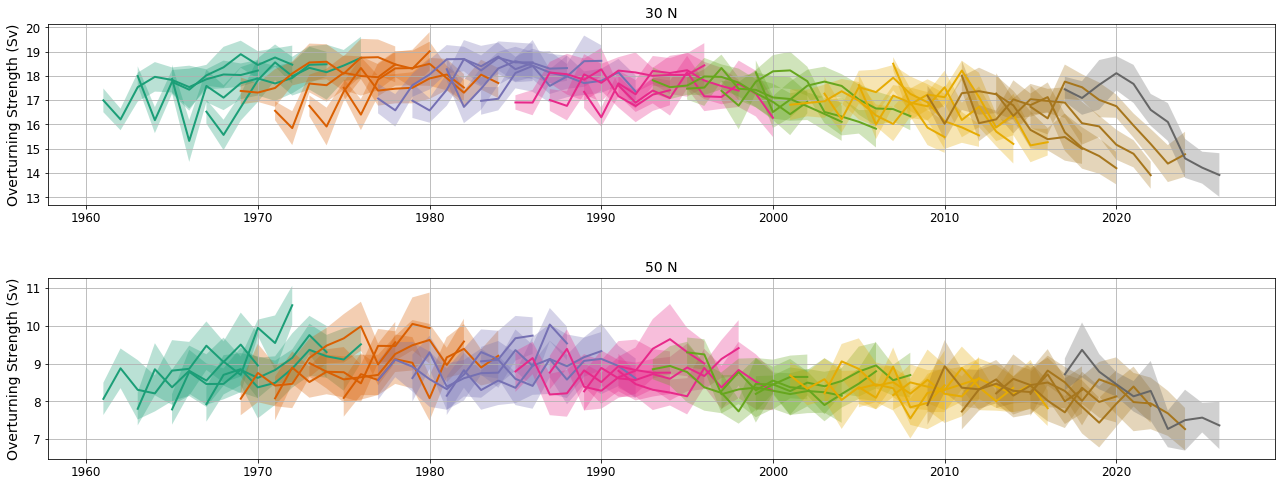

In [6]:
N = 10 # Ensembles
ci = 2.262 # coefficiet for N = 10 (mu = N -1) and 95% confidence interval -> Data Analysis Methods book
std_err = (ci/np.sqrt(np.ceil(N)))

grid = plt.GridSpec(2, 1, wspace=0.4, hspace=0.4)
fig = plt.figure(figsize=[22,8])

col = plt.cm.Dark2(np.linspace(0.,0.9, len(ds.start_year)))

for i in range(0,2):
    
    ax = fig.add_subplot(grid[i, 0])
    
    for j in range(0,len(ds.start_year)):
        
        tmp = (psi_max.isel(y=i, start_year=j, time_counter=slice(2,122))).max(dim='depthw').groupby('time_centered.year').mean('time_counter')
        ax.plot(tmp.year, tmp.mean('r'), lw = 2., color=col[j])
        ax.fill_between(tmp.year, tmp.mean('r') - std_err*tmp.std('r'), tmp.mean('r') + std_err*tmp.std('r'), 
                        facecolor=col[j], alpha=0.3)
        
    ax.set_ylabel(r'Overturning Strength (Sv)', fontsize=14)
    #ax.set_xlabel('Time', fontsize=14)
    plt.title(lat[i], fontsize=14)
    ax.grid()
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)

### Heat and Salt transport at 30N and 50N

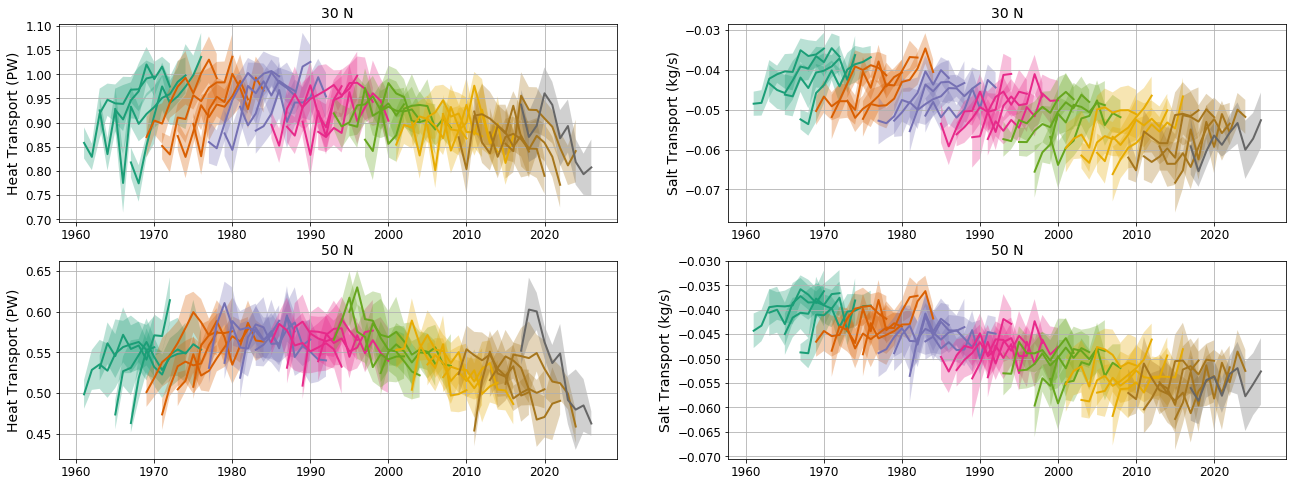

In [5]:
HT = ds['hfbasin_atlantic'].mean(['x'])
HT = HT.assign_coords(y=ds.nav_lat.isel(x=0))
HT = HT.sel(y=[30., 50.], method="nearest")

ST = ds['sltbasin_atlantic'].mean(['x'])
ST = ST.assign_coords(y=ds.nav_lat.isel(x=0))
ST = ST.sel(y=[30., 50.], method="nearest")

N = 10 # Ensembles
ci = 2.262 # coefficiet for N = 10 (mu = N -1) and 95% confidence interval -> Data Analysis Methods book
std_err = (ci/np.sqrt(np.ceil(N)))

col = plt.cm.Dark2(np.linspace(0.,0.9, len(ds.start_year)))

grid = plt.GridSpec(2, 2, wspace=0.2, hspace=0.2)
fig = plt.figure(figsize=[22,8])

for i in range(0,2):
    ax = fig.add_subplot(grid[i, 0])

    for j in range(0,len(ds.start_year)):

        tmp = (HT.isel(y=i, start_year=j, time_counter=slice(2,122))).groupby('time_centered.year').mean('time_counter')
        ax.plot(tmp.year, tmp.mean('r'), lw = 2., color=col[j])
        ax.fill_between(tmp.year, tmp.mean('r') - std_err*tmp.std('r'), tmp.mean('r') + std_err*tmp.std('r'), 
                        facecolor=col[j], alpha=0.3)

    ax.set_ylabel(r'Heat Transport (PW)', fontsize=14)
    #ax.set_xlabel('Time', fontsize=14)
    plt.title(lat[i], fontsize=14)
    ax.grid()
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)

for i in range(0,2):
    ax = fig.add_subplot(grid[i, 1])

    for j in range(0,len(ds.start_year)):

        tmp = (ST.isel(y=i, start_year=j, time_counter=slice(2,122))).groupby('time_centered.year').mean('time_counter')
        ax.plot(tmp.year, tmp.mean('r'), lw = 2., color=col[j])
        ax.fill_between(tmp.year, tmp.mean('r') - std_err*tmp.std('r'), tmp.mean('r') + std_err*tmp.std('r'), 
                        facecolor=col[j], alpha=0.3)

    ax.set_ylabel(r'Salt Transport (kg/s)', fontsize=14)
    #ax.set_xlabel('Time', fontsize=14)
    plt.title(lat[i], fontsize=14)
    ax.grid()
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)

In [12]:
ds['hfbasin_atlantic']

<xarray.DataArray 'hfbasin_atlantic' (start_year: 29, r: 10, time_counter: 125, y: 451, x: 1)>
dask.array<shape=(29, 10, 125, 451, 1), dtype=float32, chunksize=(1, 10, 125, 451, 1)>
Coordinates:
  * time_counter   (time_counter) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    nav_lon        (y, x) float32 dask.array<shape=(451, 1), chunksize=(451, 1)>
    nav_lat        (y, x) float32 dask.array<shape=(451, 1), chunksize=(451, 1)>
    time_centered  (start_year, time_counter) object dask.array<shape=(29, 125), chunksize=(1, 125)>
  * start_year     (start_year) int64 1960 1962 1964 1966 ... 2012 2014 2016
Dimensions without coordinates: r, y, x
Attributes:
    standard_name:       northward_ocean_heat_transport
    long_name:           Advective Heat Transport
    units:               PW
    online_operation:    average
    interval_operation:  900 s
    interval_write:      1 month
    cell_methods:        time: mean (interval: 900 s)

### Heat and Salt Anomalies

We compute heat and salt anomly treds (in the upper 1300 m) and comapre against Williams et al. (2015).

$$Q' = \rho_oC_p \int_{-z}^{0}\theta'(x,y,z,t)dz$$
$$S' = \int_{-z}^{0}s'(x,y,z,t)dz$$

In [3]:
dz = ds['deptht_bounds'].isel(start_year=0, r=0, time_counter=0).diff('axis_nbounds')

rho = 1035.0
cp = 4185.5

# compute time-mean T and S

T_mean = ds['zotematl'].mean(['start_year','time_counter', 'r', 'x'])
S_mean = ds['zosalatl'].mean(['start_year','time_counter', 'r', 'x'])

T_mean = T_mean.assign_coords(y=ds.nav_lat.isel(x=0))
S_mean = S_mean.assign_coords(y=ds.nav_lat.isel(x=0))

Q = rho * cp * T_mean

In [14]:
T = ds['zotematl'].assign_coords(y=ds.nav_lat.isel(x=0))
tmp = (T.isel(start_year=j, time_counter=slice(2,122)).sel(y=slice(5.,46.)))

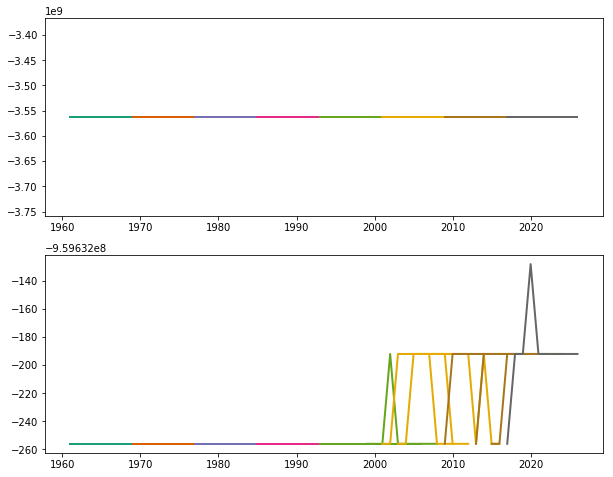

In [16]:
T = ds['zotematl'].assign_coords(y=ds.nav_lat.isel(x=0))

col = plt.cm.Dark2(np.linspace(0.,0.9, len(ds.start_year)))

grid = plt.GridSpec(2, 2, wspace=0.2, hspace=0.2)
fig = plt.figure(figsize=[22,8])

for i in range(0,2):
    ax = fig.add_subplot(grid[i, 0])

    for j in range(0,len(ds.start_year)):
        
        if(i==0):
            tmp = (T.isel(start_year=j, time_counter=slice(2,122), 
                          x=0).sel(y=slice(5.,46.)).mean(['r','y']).groupby('time_centered.year').mean('time_counter'))
            tmp = (tmp - Q.sel(y=slice(5.,46.)).mean('y')).where(tmp.deptht <= 1300.).sum('deptht')
                   
        if(i==1):
            tmp = (T.isel(start_year=j, time_counter=slice(2,122), 
                          x=0).sel(y=slice(46.,75.)).mean(['r','y']).groupby('time_centered.year').mean('time_counter'))
            tmp = (tmp - Q.sel(y=slice(46., 75.)).mean('y')).where(tmp.deptht <= 1300.).sum('deptht')
                   
        ax.plot(tmp.year, tmp, lw = 2., color=col[j])

In [12]:
print(ds['zosalatl'], ds['zotematl'])

<xarray.DataArray 'zosalatl' (start_year: 29, r: 10, time_counter: 125, deptht: 75, y: 451, x: 1)>
dask.array<shape=(29, 10, 125, 75, 451, 1), dtype=float32, chunksize=(1, 1, 125, 75, 451, 1)>
Coordinates:
    nav_lat        (y, x) float32 dask.array<shape=(451, 1), chunksize=(451, 1)>
    nav_lon        (y, x) float32 dask.array<shape=(451, 1), chunksize=(451, 1)>
  * time_counter   (time_counter) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
  * deptht         (deptht) float32 0.50576 1.5558553 ... 5698.0605 5902.0576
    time_centered  (start_year, time_counter) object dask.array<shape=(29, 125), chunksize=(1, 125)>
  * start_year     (start_year) int64 1960 1962 1964 1966 ... 2012 2014 2016
Dimensions without coordinates: r, y, x
Attributes:
    standard_name:       zonal_mean_salinity_atlantic
    long_name:           Zonal Mean Salinity : Atlantic
    units:               0.001
    online_operation:    average
    interval_operation:  900 s
    interval_write:      1 month
    cell

In [ ]:
tmp.year

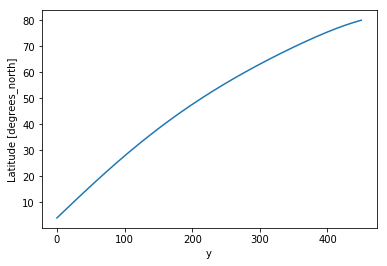

In [9]:
ds.nav_lat.plot()

In [13]:
Q

<xarray.DataArray 'zotematl' (deptht: 75, y: 451)>
dask.array<shape=(75, 451), dtype=float32, chunksize=(75, 451)>
Coordinates:
  * deptht   (deptht) float32 0.50576 1.5558553 ... 5698.0605 5902.0576
    nav_lon  (y) float32 dask.array<shape=(451,), chunksize=(451,)>
    nav_lat  (y) float32 dask.array<shape=(451,), chunksize=(451,)>
  * y        (y) float32 3.9967546 4.246108 4.495381 ... 79.91785 79.98739